In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
X = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQoZspDpm33EbFcCXEJYgH6L-Tu-a4TCrPCbZiq81fjg9r-33ayVsglzInxKav--U5L20cXB3kC9yBD/pub?output=csv')
X

,Date,Adj Close AAPL,Volume AAPL,Adj Close ABC,Volume ABC,Adj Close AMZN,Volume AMZN,Adj Close BAC,Volume BAC,Adj Close BP,Volume BP,Adj Close BRK-B,Volume BRK-B,Adj Close CVS,Volume CVS,Adj Close DDAIF,Volume DDAIF,Adj Close F,Volume F,Adj Close GOOG,Volume GOOG,Adj Close JPM,Volume JPM,Adj Close MCK,Volume MCK,Adj Close MSFT,Volume MSFT,Adj Close RDS-B,Volume RDS-B,Adj Close T,Volume T,Adj Close TM,Volume TM,Adj Close TOT,Volume TOT,Adj Close UNH,Volume UNH,Adj Close WMT,Volume WMT,Adj Close XOM,Volume XOM
0,2005-02-28,1.316963,3746232000,12.427639,20682800,35.849998,29684900,32.968975,48255000,29.017036,20998700,59.580002,3420000,20.286993,34757800,30.857567,1908600,7.875347,55751500,92.602905,77886448,24.440075,52037600,33.685661,9939700,18.084099,322103600,32.294121,2484741,10.282875,33702100,60.843304,1086900,25.259737,11717200,39.331413,20941800,37.437328,61478000,38.168442,128760400
1,2005-03-07,1.238824,4204488400,11.963464,20746800,34.750000,29673700,32.568451,41283300,28.190603,20307100,60.020000,4090000,20.391163,20628200,30.957735,1993600,7.868996,41372100,88.568024,94478205,23.527895,60048400,33.156551,8092000,18.026617,316021800,31.413136,2355602,10.077134,30300300,60.897354,1033500,25.029329,12568800,38.062389,23441200,36.379776,47133000,36.655407,170203800
2,2005-03-14,1.321578,3553877600,12.072557,18499200,34.160000,26026800,31.977856,55968800,28.584154,15497500,58.369999,5540000,20.391163,17063800,30.049568,3556300,7.233888,79130600,89.683846,88381237,23.462727,62250200,32.680378,5431700,17.466204,408338500,31.099272,2058276,9.804211,49319000,59.136475,1251700,25.292948,8275800,38.471340,25304200,36.273994,152631200,37.616077,112404900
3,2005-03-21,1.307426,2055071200,12.122155,8516800,32.880001,23236100,31.131090,50533000,26.983763,15531900,57.900002,2980000,20.622667,14253200,29.655588,2137700,7.170377,58470600,89.290321,43493615,22.759045,55754800,33.553383,5021800,17.444654,331673700,29.518976,1687673,9.783216,33866900,57.777191,1247600,24.109774,7194000,39.145905,19556000,35.822327,70161800,35.424568,88667200
4,2005-03-28,1.257898,2409145200,11.179917,59184000,34.009998,24386400,31.316097,59839000,27.442883,15717000,56.299999,7005000,19.893456,21744600,29.415186,2320700,7.100514,44289100,89.683846,69053262,22.315981,68257400,33.385845,13055700,17.329697,310621300,29.975990,1933535,9.934374,47158800,57.360142,1306800,24.425285,6156000,40.402290,31713800,34.641449,82434700,36.355190,104896100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831,2021-02-01,136.555939,439133200,109.235848,7789100,3352.149902,25631900,32.369999,237647600,20.532003,146399000,235.160004,21424700,72.180000,31416900,80.629997,277800,11.510000,540457200,2098.000000,11380300,137.979996,56399700,183.059998,6889600,241.643448,129728600,35.270000,18538300,28.930000,185355000,150.860001,1853400,42.320000,16378400,324.510010,21410000,144.360001,35234900,49.115902,145044300
832,2021-02-08,135.369995,345301700,104.744514,5329400,3277.709961,13237600,33.369999,193834200,21.617310,95017100,242.460007,18253600,74.209999,29226300,78.190002,116100,11.450000,354260900,2104.110107,5068200,141.250000,46594800,182.240005,4000700,244.427048,100257800,36.580002,11890000,28.799999,169541900,160.490005,2934800,42.770000,16416900,328.239990,18515000,144.470001,25487800,49.676384,138395500
833,2021-02-15,129.869995,362298700,105.870003,3276200,3249.899902,13185300,34.540001,190095000,22.564486,61151200,241.850006,16915100,70.419998,46040800,81.199997,100300,11.580000,184167100,2101.139893,4782000,148.020004,45489400,177.619995,3968300,240.416275,90489300,37.730000,10287700,29.000000,146550800,153.550003,1467500,44.970001,9539700,324.579987,11655700,138.339996,62243200,52.369999,96610400
834,2021-02-22,121.260002,683784700,101.220001,4993900,3092.929932,19957700,34.709999,327837000,24.410000,110431100,240.509995,29110400,68.129997,35484

In [3]:
# convert `date` column to numerical values
# more precisely number of days since 1st january 1AD
X['Date'] = pd.to_datetime(X['Date'])
X['Date'] = X['Date'].map(dt.datetime.toordinal)

In [4]:
# make a deep copy of X dataframe, drop `Date` column,shift all columns forward
# and drop NA values
Y = X.copy(deep=True).drop(labels='Date', axis=1).shift(-1).dropna()
Y

,Adj Close AAPL,Volume AAPL,Adj Close ABC,Volume ABC,Adj Close AMZN,Volume AMZN,Adj Close BAC,Volume BAC,Adj Close BP,Volume BP,Adj Close BRK-B,Volume BRK-B,Adj Close CVS,Volume CVS,Adj Close DDAIF,Volume DDAIF,Adj Close F,Volume F,Adj Close GOOG,Volume GOOG,Adj Close JPM,Volume JPM,Adj Close MCK,Volume MCK,Adj Close MSFT,Volume MSFT,Adj Close RDS-B,Volume RDS-B,Adj Close T,Volume T,Adj Close TM,Volume TM,Adj Close TOT,Volume TOT,Adj Close UNH,Volume UNH,Adj Close WMT,Volume WMT,Adj Close XOM,Volume XOM
0,1.238824,4.204488e+09,11.963464,20746800.0,34.750000,29673700.0,32.568451,41283300.0,28.190603,20307100.0,60.020000,4090000.0,20.391163,20628200.0,30.957735,1993600.0,7.868996,41372100.0,88.568024,94478205.0,23.527895,60048400.0,33.156551,8092000.0,18.026617,316021800.0,31.413136,2355602.0,10.077134,30300300.0,60.897354,1033500.0,25.029329,12568800.0,38.062389,23441200.0,36.379776,47133000.0,36.655407,170203800.0
1,1.321578,3.553878e+09,12.072557,18499200.0,34.160000,26026800.0,31.977856,55968800.0,28.584154,15497500.0,58.369999,5540000.0,20.391163,17063800.0,30.049568,3556300.0,7.233888,79130600.0,89.683846,88381237.0,23.462727,62250200.0,32.680378,5431700.0,17.466204,408338500.0,31.099272,2058276.0,9.804211,49319000.0,59.136475,1251700.0,25.292948,8275800.0,38.471340,25304200.0,36.273994,152631200.0,37.616077,112404900.0
2,1.307426,2.055071e+09,12.122155,8516800.0,32.880001,23236100.0,31.131090,50533000.0,26.983763,15531900.0,57.900002,2980000.0,20.622667,14253200.0,29.655588,2137700.0,7.170377,58470600.0,89.290321,43493615.0,22.759045,55754800.0,33.553383,5021800.0,17.444654,331673700.0,29.518976,1687673.0,9.783216,33866900.0,57.777191,1247600.0,24.109774,7194000.0,39.145905,19556000.0,35.822327,70161800.0,35.424568,88667200.0
3,1.257898,2.409145e+09,11.179917,59184000.0,34.009998,24386400.0,31.316097,59839000.0,27.442883,15717000.0,56.299999,7005000.0,19.893456,21744600.0,29.415186,2320700.0,7.100514,44289100.0,89.683846,69053262.0,22.315981,68257400.0,33.385845,13055700.0,17.329697,310621300.0,29.975990,1933535.0,9.934374,47158800.0,57.360142,1306800.0,24.425285,6156000.0,40.402290,31713800.0,34.641449,82434700.0,36.355190,104896100.0
4,1.345573,2.708017e+09,11.471516,30875600.0,34.599998,24371600.0,31.792841,44185900.0,27.648401,16214000.0,57.650002,3505000.0,19.928171,20553400.0,28.133076,3321900.0,7.005248,43969100.0,95.666420,74025430.0,22.478876,56181500.0,33.641560,14261700.0,17.918846,339174000.0,30.559654,2834913.0,9.972164,62281800.0,58.888752,1218300.0,24.394154,7033000.0,41.499165,30453600.0,34.344475,84086800.0,36.030968,85301200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
830,136.555939,4.391332e+08,109.235848,7789100.0,3352.149902,25631900.0,32.369999,237647600.0,20.532003,146399000.0,235.160004,21424700.0,72.180000,31416900.0,80.629997,277800.0,11.510000,540457200.0,2098.000000,11380300.0,137.979996,56399700.0,183.059998,6889600.0,241.643448,129728600.0,35.270000,18538300.0,28.930000,185355000.0,150.860001,1853400.0,42.320000,16378400.0,324.510010,21410000.0,144.360001,35234900.0,49.115902,145044300.0
831,135.369995,3.453017e+08,104.744514,5329400.0,3277.709961,13237600.0,33.369999,193834200.0,21.617310,95017100.0,242.460007,18253600.0,74.209999,29226300.0,78.190002,116100.0,11.450000,354260900.0,2104.110107,5068200.0,141.250000,46594800.0,182.240005,4000700.0,244.427048,100257800.0,36.580002,11890000.0,28.799999,169541900.0,160.490005,2934800.0,42.770000,16416900.0,328.239990,18515000.0,144.470001,25487800.0,49.676384,138395500.0
832,129.869995,3.622987e+08,105.870003,3276200.0,3249.899902,13185300.0,34.540001,190095000.0,22.564486,61151200.0,241.850006,16915100.0,70.419998,46040800.0,81.199997,100300.0,11.580000,184167100.0,2101.139893,4782000.0,148.020004,45489400.0,177.619995,3968300.0,240.416275,90489300.0,37.730000,10287700.0,29.000000,146550800.0,153.550003,1467500.0,44.970001,95

In [5]:
# create additional column with intercept
X.insert(0, 'Intercept', 1)
X

,Intercept,Date,Adj Close AAPL,Volume AAPL,Adj Close ABC,Volume ABC,Adj Close AMZN,Volume AMZN,Adj Close BAC,Volume BAC,Adj Close BP,Volume BP,Adj Close BRK-B,Volume BRK-B,Adj Close CVS,Volume CVS,Adj Close DDAIF,Volume DDAIF,Adj Close F,Volume F,Adj Close GOOG,Volume GOOG,Adj Close JPM,Volume JPM,Adj Close MCK,Volume MCK,Adj Close MSFT,Volume MSFT,Adj Close RDS-B,Volume RDS-B,Adj Close T,Volume T,Adj Close TM,Volume TM,Adj Close TOT,Volume TOT,Adj Close UNH,Volume UNH,Adj Close WMT,Volume WMT,Adj Close XOM,Volume XOM
0,1,732005,1.316963,3746232000,12.427639,20682800,35.849998,29684900,32.968975,48255000,29.017036,20998700,59.580002,3420000,20.286993,34757800,30.857567,1908600,7.875347,55751500,92.602905,77886448,24.440075,52037600,33.685661,9939700,18.084099,322103600,32.294121,2484741,10.282875,33702100,60.843304,1086900,25.259737,11717200,39.331413,20941800,37.437328,61478000,38.168442,128760400
1,1,732012,1.238824,4204488400,11.963464,20746800,34.750000,29673700,32.568451,41283300,28.190603,20307100,60.020000,4090000,20.391163,20628200,30.957735,1993600,7.868996,41372100,88.568024,94478205,23.527895,60048400,33.156551,8092000,18.026617,316021800,31.413136,2355602,10.077134,30300300,60.897354,1033500,25.029329,12568800,38.062389,23441200,36.379776,47133000,36.655407,170203800
2,1,732019,1.321578,3553877600,12.072557,18499200,34.160000,26026800,31.977856,55968800,28.584154,15497500,58.369999,5540000,20.391163,17063800,30.049568,3556300,7.233888,79130600,89.683846,88381237,23.462727,62250200,32.680378,5431700,17.466204,408338500,31.099272,2058276,9.804211,49319000,59.136475,1251700,25.292948,8275800,38.471340,25304200,36.273994,152631200,37.616077,112404900
3,1,732026,1.307426,2055071200,12.122155,8516800,32.880001,23236100,31.131090,50533000,26.983763,15531900,57.900002,2980000,20.622667,14253200,29.655588,2137700,7.170377,58470600,89.290321,43493615,22.759045,55754800,33.553383,5021800,17.444654,331673700,29.518976,1687673,9.783216,33866900,57.777191,1247600,24.109774,7194000,39.145905,19556000,35.822327,70161800,35.424568,88667200
4,1,732033,1.257898,2409145200,11.179917,59184000,34.009998,24386400,31.316097,59839000,27.442883,15717000,56.299999,7005000,19.893456,21744600,29.415186,2320700,7.100514,44289100,89.683846,69053262,22.315981,68257400,33.385845,13055700,17.329697,310621300,29.975990,1933535,9.934374,47158800,57.360142,1306800,24.425285,6156000,40.402290,31713800,34.641449,82434700,36.355190,104896100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831,1,737822,136.555939,439133200,109.235848,7789100,3352.149902,25631900,32.369999,237647600,20.532003,146399000,235.160004,21424700,72.180000,31416900,80.629997,277800,11.510000,540457200,2098.000000,11380300,137.979996,56399700,183.059998,6889600,241.643448,129728600,35.270000,18538300,28.930000,185355000,150.860001,1853400,42.320000,16378400,324.510010,21410000,144.360001,35234900,49.115902,145044300
832,1,737829,135.369995,345301700,104.744514,5329400,3277.709961,13237600,33.369999,193834200,21.617310,95017100,242.460007,18253600,74.209999,29226300,78.190002,116100,11.450000,354260900,2104.110107,5068200,141.250000,46594800,182.240005,4000700,244.427048,100257800,36.580002,11890000,28.799999,169541900,160.490005,2934800,42.770000,16416900,328.239990,18515000,144.470001,25487800,49.676384,138395500
833,1,737836,129.869995,362298700,105.870003,3276200,3249.899902,13185300,34.540001,190095000,22.564486,61151200,241.850006,16915100,70.419998,46040800,81.199997,100300,11.580000,184167100,2101.139893,4782000,148.020004,45489400,177.619995,3968300,240.416275,90489300,37.730000,10287700,29.000000,146550800,153.550003,1467500,44.970001,9539700,324.579987,11655700,138.339996,62243200,52.369999,96610400
834,1,737843,121.260002,683784700,101.220001,4993900,3092.929932,19957700,34.709999,327837000,24.410000,110431100,240.509995,29110400,68.129997,35484100,

In [6]:
# let's drop last row so we have same number rows as in Y 
# (where we make forward shift by 1)
X = X.iloc[0:-1]
X.shape

(835, 42)

# Scikit-learn linear regression

In [7]:
linear_model = LinearRegression(fit_intercept=False)
fit = linear_model.fit(X, Y)

In [8]:
coefs_lib = fit.coef_
norms_lib = np.apply_along_axis(np.linalg.norm, 1, coefs_lib)

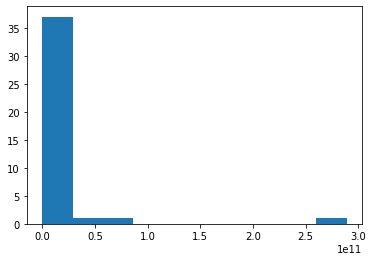

In [9]:
plt.hist(norms_lib)
plt.show()

# Regression using pseudo inverse

In [10]:
X_pinverse = np.dot(np.linalg.inv(np.dot(X.T, X)), X.T)

In [11]:
coefs_pinv = np.dot(X_pinverse, Y)
norms_pinv = np.apply_along_axis(np.linalg.norm, 0, coefs_pinv)

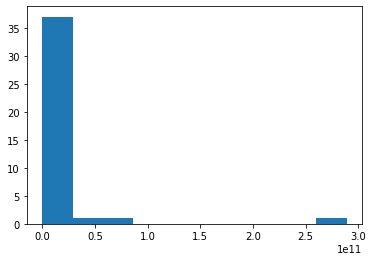

In [12]:
plt.hist(norms_pinv)
plt.show()

# QR pseudo inverse

In [13]:
Q, R = np.linalg.qr(X)
X_qr_pinverse = np.dot(np.linalg.inv(R), Q.T)

In [14]:
coefs_qr = np.dot(X_qr_pinverse, Y)
norms_qr = np.apply_along_axis(np.linalg.norm, 0, coefs_qr)

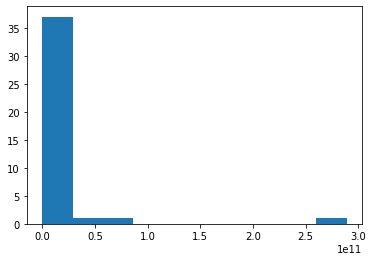

In [15]:
plt.hist(norms_qr)
plt.show()

# Deltas

In [16]:
delta_simple_QR = np.average(np.abs(coefs_pinv - coefs_qr))
delta_simple_QR
# 0.015 on local machine

0.8849542854474339

In [17]:
# The library coefficients have the different shape
delta_simple_lib = np.average(np.abs(coefs_pinv - coefs_lib.T))
delta_simple_lib
# 0.21 on local machine

0.8370496624402638

In [18]:
delta_lib_QR = np.average(np.abs(coefs_lib.T - coefs_qr))
delta_lib_QR
# 0.22 on local machine

0.18280862810505602

Input data is different on local machine. 
Especially the volume